In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from file_handler import HistoryHandler
from functions import compute_RE, get_timing_info
from Paper.figure_scripts import common

In [2]:
L = 64
alpha = 1
arch = f"RBM_alpha{alpha}"
n_dim = 1
PBC = True
dtype_labels = [None, "f32", "f16", "bf16"]
model_labels = ["TFIM"]
model_params = [{"J": 1, "h": 0.5}, {"J": 1}]
which = ["Grad", "Expect", "Both"]

n_samples = 2**17
n_chains = 2**15
M = 1000

folder = f"{PROJECT_ROOT}Data/History/LPE/"
folder_high_diag = f"{PROJECT_ROOT}Data/History/LPE_diag_shift_1e-1/"

In [3]:
DMRG_energies = []

for m in range(len(model_labels)):
    df_dmrg = pd.read_csv(f"{PROJECT_ROOT}Data/DMRG/Energy/{model_labels[m]}_1dim.csv")
    for key, value in model_params[m].items():
        df_dmrg = df_dmrg[df_dmrg[key] == value] 
    df_dmrg = df_dmrg[df_dmrg["L"] == L] 
    DMRG_energies.append(df_dmrg["energy"].to_numpy())

DMRG_energies = np.array(DMRG_energies)

In [4]:
def load(which, folder):
    loss_functions = [[None for _ in dtype_labels] for _ in model_labels]
    variance = [[None for _ in dtype_labels] for _ in model_labels]
    total_time = [[None for _ in dtype_labels] for _ in model_labels]
    re = [[None for _ in dtype_labels] for _ in model_labels]
    timinig_info = [[None for _ in dtype_labels] for _ in model_labels]
    condition_number = [[None for _ in dtype_labels] for _ in model_labels]

    for m in range(len(model_labels)):
        for d in range(len(dtype_labels)):
            if dtype_labels[d] is not None:
                _folder = f"{which}/{dtype_labels[d]}/"
            else:
                _folder = "" 
            name = f"{folder}{_folder}MC/"
            hh = HistoryHandler(name, model_labels[m], arch, L, PBC, n_dim, **model_params[m])#, n_samples=n_samples, n_chains=n_chains)
            df = hh.load_history()

            loss_functions[m][d] = df["Mean"].to_numpy()
            variance[m][d] = df["Variance"].to_numpy()
            total_time[m][d] = df["total_time"].to_numpy()[0]
            re[m][d] = compute_RE(DMRG_energies[m], df["Mean"].to_numpy())
            timinig_info[m][d] = get_timing_info(hh.history_file)

    return loss_functions, variance, total_time, re, timinig_info, condition_number

In [5]:
loss_functions_e, variance_e, total_time_e, re_e, timinig_info_e, condition_number_e = load("Expect", folder)
loss_functions_g, variance_g, total_time_g, re_g, timinig_info_g, condition_number_g = load("Grad", folder)
loss_functions_b, variance_b, total_time_b, re_b, timinig_info_b, condition_number_b = load("Both", folder)

loss_functions_e_hd, variance_e_hd, total_time_e_hd, re_e_hd, timinig_info_e_hd, condition_number_e_hd = load("Expect", folder_high_diag)
loss_functions_g_hd, variance_g_hd, total_time_g_hd, re_g_hd, timinig_info_g_hd, condition_number_g_hd = load("Grad", folder_high_diag)
loss_functions_b_hd, variance_b_hd, total_time_b_hd, re_b_hd, timinig_info_b_hd, condition_number_b_hd = load("Both", folder_high_diag)

dtype_labels[0] = "f64"

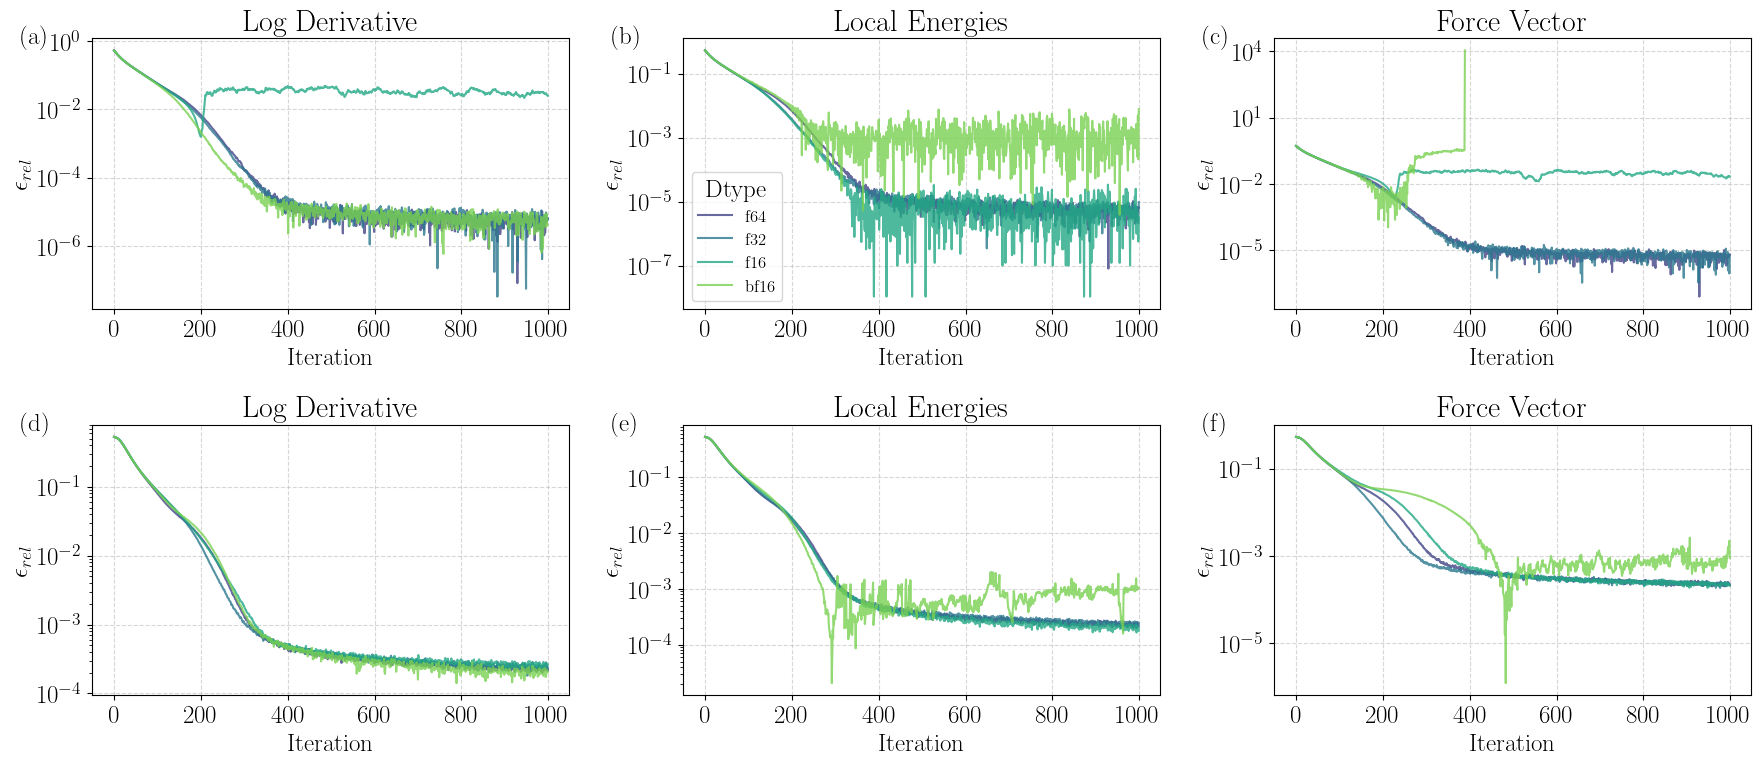

In [6]:
plt.figure(figsize=(18, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(dtype_labels)))
data = [[re_g, re_e, re_b], [re_g_hd, re_e_hd, re_b_hd]]
method_label = [r'Log Derivative', r'Local Energies', r'Force Vector']

m = 0

for R, RE in enumerate(data):
    for r, re in enumerate(RE):
        plt.subplot(len(data), len(RE), len(RE) * R + r + 1)
        plt.text(-0.15, 1.05, f'({chr(97+len(RE) * R + r)})', transform=plt.gca().transAxes, va='top')
        plt.title(f"{method_label[r]}")  
        for d in range(len(dtype_labels)):
            x = np.arange(len(re[m][d][:M]))
            y = re[m][d][:M]
            line, = plt.plot(x, y, color=colors[d], label=dtype_labels[d], alpha=0.8)
        plt.ylabel(r"$\epsilon_{rel}$")
        plt.xlabel("Iteration")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.yscale("log")

        if R == 0 and r == 1:
            plt.legend(loc='lower left', title="Dtype", frameon=True)

plt.tight_layout()
plt.savefig('figures/LPEO.pdf')
plt.show()

In [7]:
n_samples = 2**17
n_chains = 2**15
dtype_labels = [None, "f32", "f16", "bf16"]

folder = f"{PROJECT_ROOT}Data/History/Condition_number/LPE/"

In [8]:
def load(which):
    condition_number = [[None for _ in dtype_labels] for _ in model_labels]

    for m in range(len(model_labels)):
        for d in range(len(dtype_labels)):
            if dtype_labels[d] is not None:
                _folder = f"{which}/{dtype_labels[d]}/"
            else:
                _folder = "" 
            name = f"{folder}{_folder}MC/"
            hh = HistoryHandler(name, model_labels[m], arch, L, PBC, n_dim, **model_params[m], n_samples=n_samples, n_chains=n_chains)
            df = hh.load_history()

            condition_number[m][d] = df["Condition_number"].to_numpy()

    return condition_number

condition_number = load("Both")
dtype_labels[0] = "f64"

In [9]:
np.array(condition_number).shape

(1, 4, 2000)

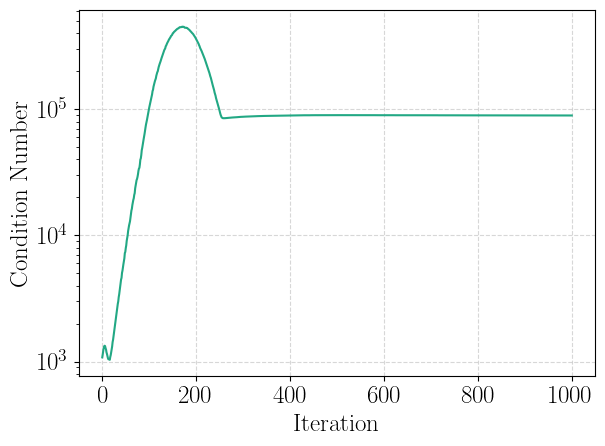

In [11]:
plt.plot(np.arange(len(condition_number[m][0][:M])), condition_number[m][0][:M], color=colors[2])
plt.xlabel('Iteration')
plt.ylabel('Condition Number')

plt.grid(alpha=0.5, ls='--')
plt.yscale('log')
plt.tight_layout()
plt.savefig('figures/condition_number.pdf')
plt.show()